In [ ]:
%%capture
!pip install timm accelerate datasets evaluate torchvision albumentations opencv-python

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
import torchvision
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
image = torch.zeros((1, 3, 800, 800)).float()
bbox = torch.FloatTensor([[20, 30, 400, 500], [300, 400, 500, 600]]) # [y1, x1, y2, x2] format
labels = torch.LongTensor([6, 8]) # 0 represents background
sub_sample = 16

In [ ]:
def show_sample(img, boxes, labels=None):
    plt.imshow(img[0].permute(1,2,0))
    ax = plt.gca()
    n_targets = boxes.shape[0]
    for idx in range(n_targets):
        x1, y1, x2, y2 = list(boxes[idx])
        ax.add_patch(plt.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, fill=False, color="red"))
        if labels is not None:
            ax.text(x1,y1,f"{labels[idx]}",color="white")
    plt.show()

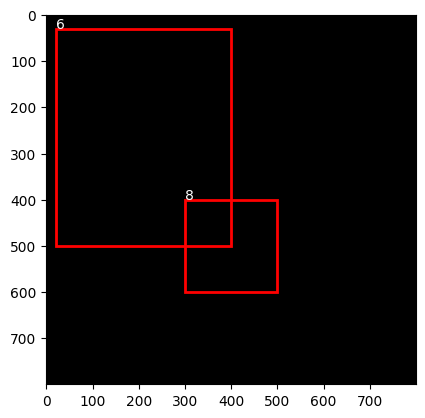

In [ ]:
show_sample(image, bbox, labels)

In [ ]:
dummy_img = torch.zeros((1, 3, 800, 800)).float()

In [ ]:
model = torchvision.models.vgg16(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 137MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
fe = list(model.features)

In [ ]:
req_features = []
k = dummy_img.clone()
for i in fe:
    with torch.no_grad():
        k = i(k)
    if k.size()[2] < 800//16:
        break
    req_features.append(i)
    out_channels = k.size()[1]
print(len(req_features)) #30
print(out_channels) # 512

30
512


In [ ]:
faster_rcnn_fe_extractor = nn.Sequential(*req_features)
faster_rcnn_fe_extractor.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [ ]:
module_names = ['features.0', 'features.2', 'features.5', 'features.7', 'features.10', 'features.12', 'features.14', 'features.17', 'features.19', 'features.21', 'features.24', 'features.26', 'features.28']

# Define a dictionary to store the outputs of selected layers
outputs_dict = {}

# Register hooks to capture the output of layers specified in module_names
def hook_fn(module, input, output, name):
    if name in module_names:
        outputs_dict[name] = output

# Attach hooks to each layer in the VGG19 model
for name, layer in model.named_modules():
    layer.register_forward_hook(lambda module, input, output, name=name: hook_fn(module, input, output, name))

# Set the model to evaluation mode
model.eval()

# Example input tensor (you can replace this with your own input data)
input_tensor = torch.randn(1, 3, 224, 224)  # Batch size 1, 3 channels, 224x224 image

# Forward pass to capture the activations of selected layers
with torch.no_grad():
    _ = model(input_tensor)

In [ ]:
ratio = torch.tensor([0.5, 1, 2]).float()
anchor_scales = torch.tensor([8, 16, 32]).float()
l = len(ratio) * len(anchor_scales)

In [ ]:
p1 = anchor_scales[:,None] * torch.sqrt(ratio[None, :])
p2 = anchor_scales[:,None] *  (1 / torch.sqrt(ratio[None, :]))
anchor_sizes = torch.stack([p1, p2], dim=-1).reshape(-1, 2) * sub_sample

In [ ]:
anchor_centers = torch.stack(torch.meshgrid([torch.arange(16, 51 * 16, 16), torch.arange(16, 51 * 16, 16)]),dim=-1)-torch.tensor([8,8])

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
anchor_centers = anchor_centers.unsqueeze(2).repeat_interleave(l, 2)

In [ ]:
anchor_sizes = anchor_sizes[None, None, :].repeat_interleave(50, 0).repeat_interleave(50,1)

In [ ]:
anchors = torch.cat([anchor_centers,anchor_sizes],dim=-1).reshape(-1,4)

In [ ]:
# yxhw -> yxyx
mins = anchors[:,0:2] - anchors[:,2:4]/2
maxs = anchors[:,0:2] + anchors[:,2:4]/2
anchors = torch.cat([mins, maxs], dim=-1)
anchors.shape

torch.Size([22500, 4])

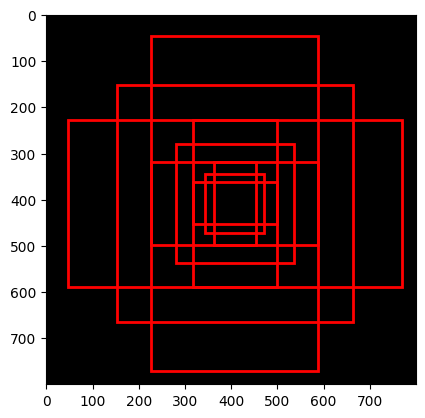

In [ ]:
show_sample(image, anchors.reshape(50,50,-1,4)[25,25])

In [ ]:
index_inside = torch.where(
        (anchors[:, 0] >= 0) &
        (anchors[:, 1] >= 0) &
        (anchors[:, 2] <= 800) &
        (anchors[:, 3] <= 800)
    )[0]
print(index_inside.shape)

torch.Size([8940])


In [ ]:
label = torch.empty((len(index_inside), ), dtype=torch.int32)
label.fill_(-1)
print(label.shape)

torch.Size([8940])


In [ ]:
valid_anchor_boxes = anchors[index_inside]
print(valid_anchor_boxes.shape)

torch.Size([8940, 4])


In [ ]:
def iou(box1, box2):
    qox = box1.unsqueeze(1)
    box = box2.unsqueeze(0)
    xi = torch.minimum(qox[...,3],box[...,3]) - torch.maximum(qox[...,1],box[...,1])
    yi = torch.minimum(qox[...,2],box[...,2]) - torch.maximum(qox[...,0],box[...,0])
    a1 = (qox[...,3] - qox[...,1]) * (qox[...,2]-qox[...,0])
    a2 = (box[...,3] - box[...,1]) * (box[...,2]-box[...,0])
    inter = torch.where(torch.logical_and(xi >= 0, yi >= 0), xi * yi, 0)
    return (inter/(a1 + a2 - inter))

In [ ]:
ious = iou(valid_anchor_boxes, bbox)

In [ ]:
ious.shape

torch.Size([8940, 2])

In [ ]:
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)
gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

tensor([2264, 4097])
tensor([0.6813, 0.6104])


In [ ]:
argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)
max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

torch.Size([8940])
tensor([0, 0, 0,  ..., 0, 0, 0])
tensor([0.0736, 0.0813, 0.0816,  ..., 0.0000, 0.0000, 0.0000])


In [ ]:
pos_iou_threshold  = 0.7
neg_iou_threshold = 0.3

In [ ]:
label[max_ious < neg_iou_threshold] = 0
label[max_ious >= pos_iou_threshold] = 1
label[gt_argmax_ious] = 1

In [ ]:
pos_ratio = 0.5
n_sample = 256
n_pos = pos_ratio * n_sample

In [ ]:
pos_index = torch.where(label == 1)[0]
if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
    label[disable_index] = -1

In [ ]:
max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox)

tensor([[ 20.,  30., 400., 500.],
        [ 20.,  30., 400., 500.],
        [ 20.,  30., 400., 500.],
        ...,
        [ 20.,  30., 400., 500.],
        [ 20.,  30., 400., 500.],
        [ 20.,  30., 400., 500.]])


In [ ]:
## yxyx -> cxcywh
height = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
width = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
ctr_y = valid_anchor_boxes[:, 0] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 1] + 0.5 * width

base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_ctr_y = max_iou_bbox[:, 0] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 1] + 0.5 * base_width

In [ ]:
# Faster RCNN parametrization (see paper)
eps = torch.tensor(1e-10).float()
height = torch.maximum(height, eps)
width = torch.maximum(width, eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = torch.log(base_height / height)
dw = torch.log(base_width / width)
anchor_locs = torch.vstack((dy, dx, dh, dw)).transpose(0,1)

In [ ]:
print(anchor_locs.shape)

torch.Size([8940, 4])


In [ ]:
anchor_labels = torch.empty((len(anchors),), dtype=label.dtype)
anchor_labels.fill_(-1)
anchor_labels[index_inside] = label

In [ ]:
anchor_locations = torch.empty((len(anchors),) + anchors.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill_(0)
anchor_locations[index_inside, :] = anchor_locs

In [ ]:
anchors.shape

torch.Size([22500, 4])

## RPN

In [ ]:
mid_channels = 512
in_channels = 512 # depends on the output feature map. in vgg 16 it is equal to 512
n_anchor = 9 # Number of anchors at each location
conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
reg_layer = nn.Conv2d(mid_channels, n_anchor *4, 1, 1, 0)
cls_layer = nn.Conv2d(mid_channels, n_anchor *2, 1, 1, 0)

In [ ]:
# conv sliding layer
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()
# Regression layer
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()
# classification layer
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
conv1.eval()
reg_layer.eval()
cls_layer.eval()
pred_anchor_locs = None
pred_cls_scores = None
with torch.no_grad():
    out_map = faster_rcnn_fe_extractor(image)
    x = conv1(out_map)
    pred_anchor_locs = reg_layer(x)
    pred_cls_scores = cls_layer(x)
print(pred_cls_scores.shape, pred_anchor_locs.shape)

torch.Size([1, 18, 50, 50]) torch.Size([1, 36, 50, 50])


In [ ]:
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[..., 1].contiguous().view(1, -1)
print(objectness_score.shape)

pred_cls_scores  = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


## Generating proposals

In [ ]:
nms_thresh = 0.7
n_train_pre_nms = 12000
n_train_post_nms = 2000
n_test_pre_nms = 6000
n_test_post_nms = 300
min_size = 16

In [ ]:
anc_height = anchors[:, 2] - anchors[:, 0]
anc_width = anchors[:, 3] - anchors[:, 1]
anc_ctr_y = anchors[:, 0] + 0.5 * anc_height
anc_ctr_x = anchors[:, 1] + 0.5 * anc_width

In [ ]:
# Undo parametrization
pred_anchor_locs = pred_anchor_locs[0]
objectness_score = objectness_score[0]
dy = pred_anchor_locs[:, 0]
dx = pred_anchor_locs[:, 1]
dh = pred_anchor_locs[:, 2]
dw = pred_anchor_locs[:, 3]
ctr_y = dy * anc_height + anc_ctr_y
ctr_x = dx * anc_width + anc_ctr_x
h = torch.exp(dh) * anc_height
w = torch.exp(dw) * anc_width

In [ ]:
# cxcywh -> yxyx
roi = torch.zeros(pred_anchor_locs.shape).float()
roi[:, 0] = ctr_y - 0.5 * h
roi[:, 1] = ctr_x - 0.5 * w
roi[:, 2] = ctr_y + 0.5 * h
roi[:, 3] = ctr_x + 0.5 * w

In [ ]:
roi.shape

torch.Size([22500, 4])

In [ ]:
img_size = (800, 800) #Image size
roi[:, 0::2] = torch.clamp(roi[:, 0::2], 0, img_size[0])
roi[:, 1::2] = torch.clamp(roi[:, 1::2], 0, img_size[1])

In [ ]:
roi

tensor([[  0.0000,   0.0000,  48.8017, 107.8779],
        [  0.0000,   0.0000,  74.8127,  73.0768],
        [  0.0000,   0.0000, 100.8478,  53.8245],
        ...,
        [605.3853, 419.2138, 800.0000, 800.0000],
        [542.1863, 532.2198, 800.0000, 800.0000],
        [419.9041, 609.7684, 800.0000, 800.0000]])

In [ ]:
hs = roi[:, 2] - roi[:, 0]
ws = roi[:, 3] - roi[:, 1]
keep = torch.where((hs >= min_size) & (ws >= min_size))[0]
roi = roi[keep, :]
score = objectness_score[keep]
print(score.shape)

torch.Size([22500])


In [ ]:
order = score.argsort(descending=True)
print(order)

tensor([   14,  1337, 22037,  ...,   433,   448,   898])


In [ ]:
order = order[:n_train_pre_nms]
all_roi = roi.detach().clone()
roi = roi[order, :]
print(roi.shape)
print(roi)

torch.Size([12000, 4])
tensor([[  0.0000,   0.0000, 186.5528, 109.3757],
        [  0.0000, 684.8958, 210.7721, 800.0000],
        [589.3704, 682.8979, 800.0000, 800.0000],
        ...,
        [  0.0000, 115.2373, 626.6211, 477.0998],
        [ 94.7831, 451.2373, 800.0000, 800.0000],
        [254.7830, 291.2373, 800.0000, 653.0999]])


In [ ]:
keep = []
croi = roi.detach().clone()
corder = order.detach().clone()
while len(corder) >= 1:
    keep.append(corder[0])
    keep_mask = torch.where(iou(croi[0][None, :], croi) <= nms_thresh, True, False)[0]
    corder = corder[keep_mask]
    croi = croi[keep_mask]

In [ ]:
keep = keep[:n_train_post_nms] # while training/testing , use accordingly
nms_roi = all_roi[keep]

In [ ]:
nms_roi.shape

torch.Size([1849, 4])

## Proposal targets

In [ ]:
n_sample = 128
pos_ratio = 0.25
pos_iou_thresh = 0.5
neg_iou_thresh_hi = 0.5
neg_iou_thresh_lo = 0.0

In [ ]:
ious2 = iou(nms_roi, bbox)
ious2.shape

torch.Size([1849, 2])

In [ ]:
gt_assignment = ious2.argmax(axis=1)
max_iou = ious2.max(axis=1)
print(gt_assignment)
print(max_iou)

tensor([0, 0, 0,  ..., 0, 0, 0])
torch.return_types.max(
values=tensor([0.0712, 0.0000, 0.0000,  ..., 0.5025, 0.4401, 0.5490]),
indices=tensor([0, 0, 0,  ..., 0, 0, 0]))


In [ ]:
gt_roi_label = labels[gt_assignment]
gt_roi_label

tensor([6, 6, 6,  ..., 6, 6, 6])

In [ ]:
pos_index = torch.where(max_iou.values >= pos_iou_thresh)[0]

tensor([  85,   90,  289,  299,  300,  303,  309,  313,  324,  462,  463, 1313,
        1386, 1544, 1560, 1742, 1837, 1846, 1848])

In [ ]:
pos_roi_per_this_image = int(min(int(n_sample * pos_ratio), pos_index.size(0)))
if pos_index.size(0) > 0:
    pos_index = np.random.choice(pos_index.numpy(), size=pos_roi_per_this_image, replace=False)
print(pos_roi_per_this_image)
print(pos_index)

19
[1313 1846  462 1560 1386  463   85  299  289  309  324 1848  300 1837
 1742  313  303 1544   90]


In [ ]:
neg_index = torch.where((max_iou.values < neg_iou_thresh_hi) &
                             (max_iou.values >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image,
                                 neg_index.size(0)))
if  neg_index.size(0) > 0 :
    neg_index = np.random.choice(
        neg_index.numpy(), size=neg_roi_per_this_image, replace=False)
print(neg_roi_per_this_image)
print(neg_index)

109
[ 550  741  292   53 1235  290 1198  939 1608 1569  798 1165  593 1625
 1841 1186 1499 1258 1813  673 1824 1233 1484 1316  364 1014  651 1237
 1426 1362 1208  390  388  278  120  853  217  513  111 1277 1778 1592
 1151 1452  542  547 1211  985  242  440  243  230  780  235 1150 1216
 1041 1463 1044 1647  700  801  164  617 1566 1763 1458  416 1436  957
  404  796   37 1492  112  861 1349 1532 1240  183  931  225  803 1170
 1506 1618 1497 1482 1634  271  491  910  992 1102  672  156  498  898
  984  518  778  731  262  512 1015  554  703 1152 1119]


In [ ]:
keep_index = np.append(pos_index, neg_index)
gt_roi_label = gt_roi_label[keep_index]
gt_roi_label[pos_roi_per_this_image:] = 0  # negative labels --> 0
sample_roi = roi[keep_index]
print(sample_roi.shape)

torch.Size([128, 4])


In [ ]:
bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)

height = sample_roi[:, 2] - sample_roi[:, 0]
width = sample_roi[:, 3] - sample_roi[:, 1]
ctr_y = sample_roi[:, 0] + 0.5 * height
ctr_x = sample_roi[:, 1] + 0.5 * width
base_height = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_width = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_y = bbox_for_sampled_roi[:, 0] + 0.5 * base_height
base_ctr_x = bbox_for_sampled_roi[:, 1] + 0.5 * base_width

torch.Size([128, 4])


In [ ]:
eps = torch.tensor(1e-10).float()
height = torch.maximum(height, eps)
width = torch.maximum(width, eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = torch.log(base_height / height)
dw = torch.log(base_width / width)
gt_roi_locs = torch.vstack((dy, dx, dh, dw)).transpose(0,1)

## RoI pooling

In [ ]:
roi_image_indices = torch.zeros((128,),dtype=torch.float32)

In [ ]:
roi_and_ind = torch.cat([sample_roi, roi_image_indices[:, None]], dim=-1)
roih = roi_and_ind[:, 2] - roi_and_ind[:, 0]
roiw = roi_and_ind[:, 3] - roi_and_ind[:, 1]
roi_and_ind[:, 2:4] = torch.vstack([roih, roiw]).transpose(0,1)
roi_and_ind = roi_and_ind[:,[4,1,0,2,3]]
roi_and_ind.shape

torch.Size([128, 5])

In [ ]:
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])

In [ ]:
output = []
rois = roi_and_ind
rois[:, 1:].mul_(1/16.0) # Subsampling ratio
rois = rois.long()
num_rois = rois.size(0)

In [ ]:
out_map.shape

torch.Size([1, 512, 50, 50])

In [ ]:
output = []
for i in range(num_rois):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[2]+roi[4]+1), roi[1]:(roi[1]+roi[3]+1)]
    output.append(adaptive_max_pool(im)[0])

In [ ]:
output = torch.cat(output, 0)
print(output.size())

torch.Size([128, 512, 7, 7])


In [ ]:
k = output.view(output.size(0), -1)
print(k.shape)

torch.Size([128, 25088])


In [ ]:
roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096),
                                      nn.Linear(4096, 4096)])
cls_loc = nn.Linear(4096, 21 * 4)
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()
score = nn.Linear(4096, 21)

In [ ]:
roi_head_classifier.eval()
cls_loc.eval()
score.eval()
with torch.no_grad():
    k = roi_head_classifier(k)
    roi_cls_loc = cls_loc(k)
    roi_cls_score = score(k)
print(roi_cls_loc.shape, roi_cls_score.shape)

torch.Size([128, 84]) torch.Size([128, 21])


## Loss functions

### RPN

In [ ]:
print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(anchor_locations.shape)
print(anchor_labels.shape)

torch.Size([22500, 4])
torch.Size([1, 22500, 2])
torch.Size([22500, 4])
torch.Size([22500])


In [ ]:
pred_cls_scores = pred_cls_scores[0]
gt_rpn_score = anchor_labels
gt_rpn_loc = anchor_locations

In [ ]:
import torch.nn.functional as F
rpn_cls_loss = F.cross_entropy(pred_cls_scores, gt_rpn_score.long(), ignore_index = -1)
print(rpn_cls_loss)

tensor(0.6958)


In [ ]:
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(pred_anchor_locs)
print(mask.shape)

torch.Size([22500, 4])


In [ ]:
mask_loc_preds = pred_anchor_locs[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_preds.shape)

torch.Size([2, 4]) torch.Size([2, 4])


In [ ]:
x = torch.abs(mask_loc_targets - mask_loc_preds)
rpn_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float() * (x-0.5))
print(rpn_loc_loss.sum())

tensor(0.1226)


In [ ]:
rpn_lambda = 10.
N_reg = (gt_rpn_score >0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(1.3088)


### Fast RCNN

In [ ]:
print(roi_cls_loc.shape)
print(roi_cls_score.shape)
print(gt_roi_locs.shape)
print(gt_roi_label.shape)

torch.Size([128, 84])
torch.Size([128, 21])
torch.Size([128, 4])
torch.Size([128])


In [ ]:
roi_cls_loss = F.cross_entropy(roi_cls_score, gt_roi_label, ignore_index=-1)
print(roi_cls_loss)

tensor(3.0390)


In [ ]:
n_sample = roi_cls_loc.shape[0]
roi_loc = roi_cls_loc.view(n_sample, -1, 4)
print(roi_loc.shape)

roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
print(roi_loc.shape)

torch.Size([128, 21, 4])
torch.Size([128, 4])
